In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
!dpkg -i cuda-keyring_1.1-1_all.deb
!apt-get update -qq

--2025-12-29 08:28:48--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 173.223.234.208, 173.223.234.202, 173.223.234.197, ...
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|173.223.234.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332 (4.2K) [application/x-deb]
Saving to: ‘cuda-keyring_1.1-1_all.deb’

cuda-keyring_1.1-1_ 100%[===================>]   4.23K  --.-KB/s    in 0s      

2025-12-29 08:28:48 (1.30 GB/s) - ‘cuda-keyring_1.1-1_all.deb’ saved [4332/4332]

(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack cuda-keyring_1.1-1_all.deb ...
Unpacking cuda-keyring (1.1-1) over (1.1-1) ...
Setting up cuda-keyring (1.1-1) ...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' doe

In [ ]:
!apt-cache search nsight-systems

nsight-systems-target - NVIDIA Nsight Systems (target specific libraries)
cuda-nsight-systems-11-7 - NVIDIA Nsight Systems
nsight-systems-2022.1.3 - Nsight Systems is a statistical sampling profiler with tracing features.
cuda-nsight-systems-11-8 - NVIDIA Nsight Systems
nsight-systems-2022.4.2 - Nsight Systems is a statistical sampling profiler with tracing features.
cuda-nsight-systems-12-0 - NVIDIA Nsight Systems
cuda-nsight-systems-12-1 - NVIDIA Nsight Systems
nsight-systems-2023.1.2 - Nsight Systems is a statistical sampling profiler with tracing features.
cuda-nsight-systems-12-2 - NVIDIA Nsight Systems
nsight-systems-2023.2.3 - Nsight Systems is a statistical sampling profiler with tracing features.
cuda-nsight-systems-12-3 - NVIDIA Nsight Systems
nsight-systems-2023.3.3 - Nsight Systems is a statistical sampling profiler with tracing features.
cuda-nsight-systems-12-4 - NVIDIA Nsight Systems
nsight-systems-2023.4.4 - Nsight Systems is a statistical sampling profiler with tracing

In [1]:
!apt-get install -y nsight-systems-2025.5.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxcb-cursor0 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxcomposite1 libxkbcommon-x11-0 libxtst6
The following NEW packages will be installed:
  libxcb-cursor0 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxcomposite1 libxkbcommon-x11-0 libxtst6 nsight-systems-2025.5.2
0 upgraded, 13 newly installed, 0 to remove and 41 not upgraded.
Need to get 411 MB of archives.
After this operation, 784 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  nsight-systems-2025.5.2 2025.5.2.266-255236693005v0 [411 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxcb-xinerama0 amd64 1.14-3ubuntu3 [5,414 B]

In [2]:
!nsys --version

NVIDIA Nsight Systems version 2025.5.2.266-255236693005v0


In [3]:
!ls -d /opt/nvidia/nsight-systems/*/bin/nsys

/opt/nvidia/nsight-systems/2025.5.2/bin/nsys


In [4]:
# Add to PATH for the current session
import os
os.environ['PATH'] += ":/opt/nvidia/nsight-systems/2025.5.2/bin"

# Check version
!nsys --version

NVIDIA Nsight Systems version 2025.5.2.266-255236693005v0


In [5]:
# Create project directory
!mkdir -p cuda_edge_detection
%cd cuda_edge_detection

/content/cuda_edge_detection


In [22]:
# Create kernels.h
%%writefile kernels.h
#ifndef KERNELS_H
#define KERNELS_H

void launch_rgb2gray(const unsigned char* d_rgb, float* d_gray, int w, int h);
void launch_gaussian_blur(const float* d_in, float* d_out, int w, int h);
void launch_sobel(const float* d_in, float* d_out, int w, int h);
void launch_float2uchar(const float* d_in, unsigned char* d_out, int w, int h);
void launch_normalize_sobel(const float* d_in, unsigned char* d_out, int w, int h);

#endif

Overwriting kernels.h


In [23]:
# Create kernels.cu
%%writefile kernels.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <math.h>

#define K_SIZE 3
#define R (K_SIZE / 2)
#define BLOCK_SIZE 16
#define TILE_SIZE (BLOCK_SIZE + 2 * R)

// constant memory for sobel kernels
__constant__ float Gx[9] = {-1, 0, 1, -2, 0, 2, -1, 0, 1};
__constant__ float Gy[9] = {-1, -2, -1, 0, 0, 0, 1, 2, 1};

// constant memory for Gaussian Blur
__constant__ float G_Blur[9] = {
    1.0f / 16.0f, 2.0f / 16.0f, 1.0f / 16.0f,
    2.0f / 16.0f, 4.0f / 16.0f, 2.0f / 16.0f,
    1.0f / 16.0f, 2.0f / 16.0f, 1.0f / 16.0f
};

// kernel-1: RGB to Grayscale conversion
__global__ void rgb2gray(const unsigned char* rgb, float *gray, int width, int height){
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if (col < width && row < height){
        int idx = (row * width + col) * 3;
        unsigned char r = rgb[idx];
        unsigned char g = rgb[idx + 1];
        unsigned char b = rgb[idx + 2];

        gray[row * width + col] = (0.299f * r + 0.587f * g + 0.114f * b) / 255.0f;
    }
}

// kernel-2: Gaussian Blur
__global__ void gaussian_blur(const float* in, float *out, int width, int height){
    __shared__ float sdata[TILE_SIZE][TILE_SIZE + 1];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int col = blockIdx.x * blockDim.x + tx;
    int row = blockIdx.y * blockDim.y + ty;

    int tile_start_row = blockIdx.y * BLOCK_SIZE - R;
    int tile_start_col = blockIdx.x * BLOCK_SIZE - R;

    for (int i = ty; i < TILE_SIZE; i += BLOCK_SIZE){
        for (int j = tx; j < TILE_SIZE; j += BLOCK_SIZE){
            int global_row = tile_start_row + i;
            int global_col = tile_start_col + j;

            global_row = max(0, min(height - 1, global_row));
            global_col = max(0, min(width - 1, global_col));

            sdata[i][j] = in[global_row * width + global_col];
        }
    }
    __syncthreads();

    if (col < width && row < height){
        float sum = 0.0f;
        for (int i = -R; i <= R; i++){
            for (int j = -R; j <= R; j++){
                sum += sdata[ty + R + i][tx + R + j] * G_Blur[(i + R) * K_SIZE + (j + R)];
            }
        }
        out[row * width + col] = sum;
    }
}

// kernel-3: Sobel Edge Detection - FIXED VERSION
__global__ void sobel_edge(const float* in, float *out, int width, int height){
    __shared__ float sdata[TILE_SIZE][TILE_SIZE + 1];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int col = blockIdx.x * blockDim.x + tx;
    int row = blockIdx.y * blockDim.y + ty;

    int tile_start_row = blockIdx.y * BLOCK_SIZE - R;
    int tile_start_col = blockIdx.x * BLOCK_SIZE - R;

    for (int i = ty; i < TILE_SIZE; i += BLOCK_SIZE){
        for (int j = tx; j < TILE_SIZE; j += BLOCK_SIZE){
            int global_row = tile_start_row + i;
            int global_col = tile_start_col + j;

            global_row = max(0, min(height - 1, global_row));
            global_col = max(0, min(width - 1, global_col));

            sdata[i][j] = in[global_row * width + global_col];
        }
    }
    __syncthreads();

    if (col < width && row < height){
        float sumX = 0.0f, sumY = 0.0f;
        for (int i = -R; i <= R; i++){
            for (int j = -R; j <= R; j++){
                float pixel = sdata[ty + R + i][tx + R + j];
                sumX += pixel * Gx[(i + R) * K_SIZE + (j + R)];
                sumY += pixel * Gy[(i + R) * K_SIZE + (j + R)];
            }
        }
        // Calculate magnitude and normalize to 0-1 range
        float mag = sqrtf(sumX * sumX + sumY * sumY);
        // Store the raw magnitude (will normalize later)
        out[row * width + col] = mag;
    }
}

// NEW: Find maximum value kernel
__global__ void find_max(const float* in, float* max_val, int size){
    __shared__ float sdata[256];

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Load data
    sdata[tid] = (idx < size) ? in[idx] : 0.0f;
    __syncthreads();

    // Reduction to find max
    for (int s = blockDim.x / 2; s > 0; s >>= 1){
        if (tid < s){
            sdata[tid] = fmaxf(sdata[tid], sdata[tid + s]);
        }
        __syncthreads();
    }

    // Write result
    if (tid == 0){
        atomicMax((int*)max_val, __float_as_int(sdata[0]));
    }
}

// NEW: Normalize and threshold kernel
__global__ void normalize_and_threshold(const float* in, unsigned char* out,
                                        float max_val, int width, int height){
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if (col < width && row < height){
        int idx = row * width + col;
        float normalized = (in[idx] / max_val);

        // Apply threshold and convert to 0-255
        float val = (normalized > 0.1f) ? (normalized * 255.0f) : 0.0f;
        out[idx] = (unsigned char)min(255.0f, val);
    }
}

// kernel-4: float to unsigned char conversion - SIMPLIFIED
__global__ void float2uchar(const float* in, unsigned char *out, int width, int height){
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if (col < width && row < height){
        float val = in[row * width + col] * 255.0f;
        out[row * width + col] = (unsigned char)max(0.0f, min(255.0f, val));
    }
}

// Error checking helper
#define CUDA_CHECK_KERNEL() \
    do { \
        cudaError_t err = cudaGetLastError(); \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA kernel launch error: %s\n", cudaGetErrorString(err)); \
            return; \
        } \
    } while(0)

// wrapper for RGB to Grayscale conversion
void launch_rgb2gray(const unsigned char* d_rgb, float* d_gray, int w, int h) {
    dim3 threads(16, 16);
    dim3 blocks((w + 15) / 16, (h + 15) / 16);
    rgb2gray<<<blocks, threads>>>(d_rgb, d_gray, w, h);
    CUDA_CHECK_KERNEL();
}

// Wrapper for Gaussian Blur
void launch_gaussian_blur(const float* d_in, float* d_out, int w, int h) {
    dim3 threads(16, 16);
    dim3 blocks((w + 15) / 16, (h + 15) / 16);
    gaussian_blur<<<blocks, threads>>>(d_in, d_out, w, h);
    CUDA_CHECK_KERNEL();
}

// Wrapper for Sobel
void launch_sobel(const float* d_in, float* d_out, int w, int h) {
    dim3 threads(16, 16);
    dim3 blocks((w + 15) / 16, (h + 15) / 16);
    sobel_edge<<<blocks, threads>>>(d_in, d_out, w, h);
    CUDA_CHECK_KERNEL();
}

// NEW: Wrapper for normalization
void launch_normalize_sobel(const float* d_in, unsigned char* d_out, int w, int h) {
    int size = w * h;

    // Allocate memory for max value
    float *d_max;
    cudaMalloc(&d_max, sizeof(float));
    cudaMemset(d_max, 0, sizeof(float));

    // Find maximum (simple version - copy to host)
    float *h_data = (float*)malloc(size * sizeof(float));
    cudaMemcpy(h_data, d_in, size * sizeof(float), cudaMemcpyDeviceToHost);

    float max_val = 0.0f;
    for (int i = 0; i < size; i++){
        max_val = fmaxf(max_val, h_data[i]);
    }
    free(h_data);

    printf("  Max Sobel magnitude: %.4f\n", max_val);

    // Normalize and threshold
    dim3 threads(16, 16);
    dim3 blocks((w + 15) / 16, (h + 15) / 16);
    normalize_and_threshold<<<blocks, threads>>>(d_in, d_out, max_val, w, h);
    CUDA_CHECK_KERNEL();

    cudaFree(d_max);
}

// Wrapper for Float to Uchar
void launch_float2uchar(const float* d_in, unsigned char* d_out, int w, int h) {
    dim3 threads(16, 16);
    dim3 blocks((w + 15) / 16, (h + 15) / 16);
    float2uchar<<<blocks, threads>>>(d_in, d_out, w, h);
    CUDA_CHECK_KERNEL();
}

Overwriting kernels.cu


In [8]:
# Download stb_image headers
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image.h
!wget https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h

--2026-01-22 06:18:41--  https://raw.githubusercontent.com/nothings/stb/master/stb_image.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283010 (276K) [text/plain]
Saving to: ‘stb_image.h’

stb_image.h         100%[===================>] 276.38K  --.-KB/s    in 0.04s   

2026-01-22 06:18:41 (7.47 MB/s) - ‘stb_image.h’ saved [283010/283010]

--2026-01-22 06:18:41--  https://raw.githubusercontent.com/nothings/stb/master/stb_image_write.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71221 (70K) [text/plain]
Saving to: ‘stb_image_

In [24]:
# Create main.cu
%%writefile main.cu
#include <iostream>
#include <cuda_runtime.h>
#include <vector>
#include "kernels.h"

// stb image for image loading and saving
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"

// error checking macro
#define CUDA_CHECK(call) \
    do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            std::cerr << "CUDA Error at line " << __LINE__ << ": " \
                      << cudaGetErrorString(err) << std::endl; \
            exit(1); \
        } \
    } while (0)

bool checkCudaDevice() {
    int deviceCount = 0;
    cudaError_t error = cudaGetDeviceCount(&deviceCount);

    if (error != cudaSuccess || deviceCount == 0) {
        std::cerr << "No CUDA-capable device found!" << std::endl;
        if (error != cudaSuccess) {
            std::cerr << "Error: " << cudaGetErrorString(error) << std::endl;
        }
        return false;
    }

    // Print device info
    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, 0);
    std::cout << "Using GPU: " << prop.name << std::endl;
    std::cout << "Compute Capability: " << prop.major << "." << prop.minor << std::endl;
    std::cout << "Total Global Memory: " << prop.totalGlobalMem / (1024*1024) << " MB" << std::endl;

    return true;
}

int main(int argc, char** argv) {
    if (argc < 2){
        std::cout << "Usage: " << argv[0] << " <input_image>" << std::endl;
        return -1;
    }

    // Check CUDA device
    if (!checkCudaDevice()) {
        return -1;
    }

    // load image from disk
    int width, height, channels;
    unsigned char* h_img = stbi_load(argv[1], &width, &height, &channels, 3);

    if (!h_img){
        fprintf(stderr, "Error loading image %s\n", argv[1]);
        return -1;
    }
    printf("Loaded image: %d x %d (%d channels)\n", width, height, channels);

    size_t img_size = width * height * 3 * sizeof(unsigned char);
    size_t gray_size = width * height * sizeof(float);
    size_t out_size = width * height * sizeof(unsigned char);

    std::cout << "Memory requirements:" << std::endl;
    std::cout << "  RGB image: " << img_size / (1024.0*1024.0) << " MB" << std::endl;
    std::cout << "  Float buffers (each): " << gray_size / (1024.0*1024.0) << " MB" << std::endl;
    std::cout << "  Total: " << (img_size + 3*gray_size + out_size) / (1024.0*1024.0) << " MB" << std::endl;

    // allocate device memory
    unsigned char *d_rgb = nullptr;
    unsigned char *d_final_uchar = nullptr;
    float *d_gray = nullptr;
    float *d_blur = nullptr;
    float *d_sobel = nullptr;

    std::cout << "Allocating device memory..." << std::endl;
    CUDA_CHECK(cudaMalloc((void**)&d_rgb, img_size));
    std::cout << "  d_rgb allocated" << std::endl;

    CUDA_CHECK(cudaMalloc((void**)&d_gray, gray_size));
    std::cout << "  d_gray allocated" << std::endl;

    CUDA_CHECK(cudaMalloc((void**)&d_blur, gray_size));
    std::cout << "  d_blur allocated" << std::endl;

    CUDA_CHECK(cudaMalloc((void**)&d_sobel, gray_size));
    std::cout << "  d_sobel allocated" << std::endl;

    CUDA_CHECK(cudaMalloc((void**)&d_final_uchar, out_size));
    std::cout << "  d_final_uchar allocated" << std::endl;

    // copy image to device
    std::cout << "Copying image to device..." << std::endl;
    CUDA_CHECK(cudaMemcpy(d_rgb, h_img, img_size, cudaMemcpyHostToDevice));

    printf("Running vision pipeline...\n");

    // step-1: rgb -> grayscale
    std::cout << "  1. RGB to Grayscale..." << std::endl;
    launch_rgb2gray(d_rgb, d_gray, width, height);
    CUDA_CHECK(cudaDeviceSynchronize());

    // step-2: gaussian blur
    std::cout << "  2. Gaussian Blur..." << std::endl;
    launch_gaussian_blur(d_gray, d_blur, width, height);
    CUDA_CHECK(cudaDeviceSynchronize());

    // step-3: sobel filter
    std::cout << "  3. Sobel Edge Detection..." << std::endl;
    launch_sobel(d_blur, d_sobel, width, height);
    CUDA_CHECK(cudaDeviceSynchronize());

    // convert float output to unsigned char with normalization
    std::cout << "  4. Normalizing and converting to UChar..." << std::endl;
    launch_normalize_sobel(d_sobel, d_final_uchar, width, height);
    CUDA_CHECK(cudaDeviceSynchronize());

    std::cout << "Copying results back to host..." << std::endl;
    unsigned char* h_final = (unsigned char*)malloc(out_size);
    CUDA_CHECK(cudaMemcpy(h_final, d_final_uchar, out_size, cudaMemcpyDeviceToHost));

    // Save Result to Disk
    std::cout << "Saving output image..." << std::endl;
    stbi_write_jpg("output_edges.jpg", width, height, 1, h_final, 100);
    std::cout << "Success! Result saved as 'output_edges.jpg'" << std::endl;

    // Cleanup
    stbi_image_free(h_img);
    free(h_final);

    if (d_rgb) cudaFree(d_rgb);
    if (d_gray) cudaFree(d_gray);
    if (d_blur) cudaFree(d_blur);
    if (d_sobel) cudaFree(d_sobel);
    if (d_final_uchar) cudaFree(d_final_uchar);

    return 0;
}

Overwriting main.cu


In [29]:
# Compile
!nvcc -arch=sm_75 main.cu kernels.cu -o edge_detector

# Check if compilation was successful
import os
if os.path.exists('edge_detector'):
    print("✓ Compilation successful!")
else:
    print("✗ Compilation failed")

stb_image.h(4276): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

stb_image.h(5185): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

stb_image.h(6972): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

stb_image.h(6973): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^

✓ Compilation successful!


In [39]:
!nsys profile --stats=true --trace=cuda,osrt,nvtx --cuda-memory-usage=true --output=my_timeline_report ./edge_detector adiyogi-minimalist-3840x2160-14952.png

Using GPU: Tesla T4
Compute Capability: 7.5
Total Global Memory: 15095 MB
Loaded image: 3840 x 2160 (3 channels)
Memory requirements:
  RGB image: 23.7305 MB
  Float buffers (each): 31.6406 MB
  Total: 126.562 MB
Allocating device memory...
  d_rgb allocated
  d_gray allocated
  d_blur allocated
  d_sobel allocated
  d_final_uchar allocated
Copying image to device...
Running vision pipeline...
  1. RGB to Grayscale...
  2. Gaussian Blur...
  3. Sobel Edge Detection...
  4. Normalizing and converting to UChar...
  Max Sobel magnitude: 2.2929
Copying results back to host...
Saving output image...
Success! Result saved as 'output_edges.jpg'
Generating '/tmp/nsys-report-7a37.qdstrm'
Failed to create '/content/cuda_edge_detection/my_timeline_report.nsys-rep': File exists.
Use `--force-overwrite true` to overwrite existing files.
[1/8] [========================100%] nsys-report-cdb5.nsys-rep
Failed to create '/content/cuda_edge_detection/my_timeline_report.sqlite': File exists.
Use `--force-

In [33]:
# Upload your test image using Colab's file upload
from google.colab import files
print("Upload your image:")
uploaded = files.upload()

# Get the uploaded filename
image_name = list(uploaded.keys())[0]

Upload your image:


Saving adiyogi-minimalist-3840x2160-14952.png to adiyogi-minimalist-3840x2160-14952.png


In [34]:
# Run the edge detector
!./edge_detector "adiyogi-minimalist-3840x2160-14952.png"

Using GPU: Tesla T4
Compute Capability: 7.5
Total Global Memory: 15095 MB
Loaded image: 3840 x 2160 (3 channels)
Memory requirements:
  RGB image: 23.7305 MB
  Float buffers (each): 31.6406 MB
  Total: 126.562 MB
Allocating device memory...
  d_rgb allocated
  d_gray allocated
  d_blur allocated
  d_sobel allocated
  d_final_uchar allocated
Copying image to device...
Running vision pipeline...
  1. RGB to Grayscale...
  2. Gaussian Blur...
  3. Sobel Edge Detection...
  4. Normalizing and converting to UChar...
  Max Sobel magnitude: 2.2929
Copying results back to host...
Saving output image...
Success! Result saved as 'output_edges.jpg'


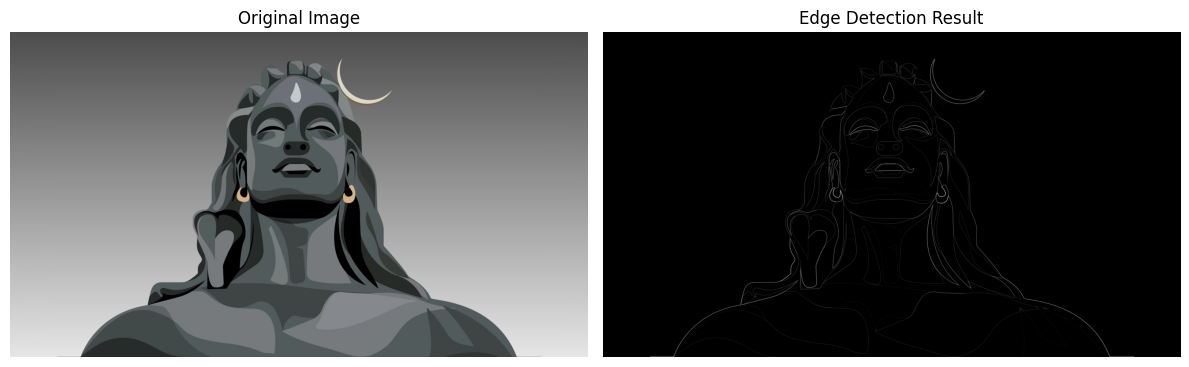

In [35]:
# Display results
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2

original = cv2.imread("adiyogi-minimalist-3840x2160-14952.png")
edges = cv2.imread('output_edges.jpg', 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection Result')
plt.axis('off')

plt.tight_layout()
plt.show()

In [36]:
# Download the result
files.download('output_edges.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>